---
# Tutorial Task: Sentiment-Based Quant Strategy
---

In this tutorial, you will design and implement a **quantitative trading strategy** that makes trading decisions based on **news sentiment** for a selected group of 3 stocks.

## Objective

Each day, over a 1-week historical period:
- **Buy** (go long) the stock with the **most positive** news sentiment
- **Sell** (go short) the stock with the **most negative** news sentiment

You will:
1. Select your own **universe of 3 stocks** (e.g., AAPL, BRK-B, DNUT, MSFT, GOOGL, AMZN, TSLA).
2. Use the provided News API to retrieve articles for each stock.
3. Calculate the **average sentiment** for each stock daily using tools like `TextBlob`.
4. Track your portfolio’s value over time by simulating simple returns.
5. Plot your portfolio value and analyze strategy performance.

## Constraints

- The News API is limited to **100 requests per day**. Avoid excessive API calls while developing by storing data or limiting requests.
- You only trade **one long and one short position** per day.
- Keep it simple: assume equal capital allocation to long and short trades.


## Step 1:
Import relevant libraries

In [23]:
#data analysis
import pandas as pd
import numpy as np 

#API call
import requests

#sentiment analysis 
from textblob import TextBlob

#Time arithmetic
from datetime import datetime, timedelta

#plotting
import matplotlib.pyplot as plt

#financial data
import yfinance as yf

## Step 2:
Configure your API

https://newsapi.org/

In [24]:
#information to call API

API_KEY = '6bbbe1f4344d44e0b3c125a0a3eb7503'
BASE_URL = 'https://newsapi.org/v2/everything'

## Step 3:
Create a function to get news and calculate the sentiment

In [25]:
#we usew textblob to calcualte sentiment 

print(TextBlob("This stock is amazing").sentiment.polarity)
print(TextBlob("This stock is okay").sentiment.polarity)
print(TextBlob("This stock is awful").sentiment.polarity)
print(TextBlob("This is a stock").sentiment.polarity)

0.6000000000000001
0.5
-1.0
0.0


In [26]:
import requests
from datetime import timedelta
import numpy as np
from textblob import TextBlob

def get_sentiment(stock, date):
    # Format dates as YYYY-MM-DD
    from_date = date.strftime('%Y-%m-%d')
    to_date   = (date + timedelta(days=1)).strftime('%Y-%m-%d')

    # Build parameters as a dict, with correct keys and commas
    params = {
        'q':        stock,
        'from':     from_date,
        'to':       to_date,
        'sortBy':   'relevancy',
        'apiKey':   API_KEY,       # use the exact key name expected by NewsAPI
        'language': 'en',          # English language code
        'pageSize': 5
    }

    # Call the API and parse JSON
    response = requests.get(BASE_URL, params=params)
    data     = response.json()
    print(data)

    # Extract sentiment polarity from each article
    sentiments = []
    for art in data.get('articles', []):
        title       = art.get('title', '') or ''
        description = art.get('description', '') or ''
        if not (title or description):
            continue

        text = f"{title} {description}"
        sentiments.append(TextBlob(text).sentiment.polarity)

    # Return the average polarity (or None if no data)
    if sentiments:
        mean_sentiment = np.mean(sentiments)
        print("Mean sentiment:", mean_sentiment)
        return mean_sentiment

    return None


In [27]:
get_sentiment('APPL', datetime(2025,5,5))


{'status': 'ok', 'totalResults': 12, 'articles': [{'source': {'id': None, 'name': 'Forbes'}, 'author': 'Robert Barone, Contributor, \n Robert Barone, Contributor\n https://www.forbes.com/sites/greatspeculations/people/robertbarone/', 'title': 'The Economy Is Slowing – Will The Fed Act In Time?', 'description': 'Markets had a positive week, with the major indexes advancing in the +3% range despite a slowing economy and less than stellar corporate reports.', 'url': 'https://www.forbes.com/sites/greatspeculations/2025/05/05/the-economy-is-slowing--will-the-fed-act-in-time/', 'urlToImage': 'https://imageio.forbes.com/specials-images/imageserve/681940ceaafb50396e9d5d4f/0x0.jpg?format=jpg&crop=829,465,x357,y0,safe&height=900&width=1600&fit=bounds', 'publishedAt': '2025-05-05T23:00:22Z', 'content': 'Markets had a positive week, with the major indexes advancing in the +3% range despite a slowing economy and less than stellar corporate reports. As of Friday (May 2nd), the S&amp;P 500 notched it

np.float64(0.06853535353535353)

## Step 4:
Simulate Trading by Backtesting

In [28]:
def gather_daily_sentiments(stocks, start_date, end_date):
    """
    For each date in [start_date, end_date], calls get_sentiment(stock, date)
    and returns a DataFrame of shape (n_dates * n_stocks) of daily polarity
    """

    dates = pd.date_range(start_date, end_date)
    # initialise and empy dataframe
    sentiments = pd.DataFrame(index=dates, columns=stocks, dtype=float)

    for date in dates:
        for stock in stocks:
            sentiments.at[date, stock] = get_sentiment(stock, date)
    return sentiments

def fetch_price_data(stocks, start_date, end_date):
    """
    Downloads daily OHLC data for each ticker in 'stocks' between start_date and end_date. Returns a dict mapping ticker to its dataframe
    """

    price_data = {}
    for stock in stocks:
        df = yf.download(
            stock,
            start = start_date.strftime('%Y-%m-%d'),
            end = (end_date + timedelta(days = 1)).strftime('%Y-%m-%d'),
            interval = '1d',
            progress = False
        )
        price_data[stock] = df[['Open', 'Close']] # keep only what is needed
    return price_data


## Step 5:
Display results in ```matplotlib```

{'status': 'ok', 'totalResults': 70, 'articles': [{'source': {'id': None, 'name': 'AppleInsider'}, 'author': 'news@appleinsider.com (Wesley Hilliard)', 'title': 'Consumers get ahead of tariffs, Morgan Stanley hikes AAPL price target to $235', 'description': "Morgan Stanley hiked its Apple stock price target to $235 because instability created by the Trump administration's tariffs may be a boon to Apple's bottom line — at least in the short term.iPhone 16 Pro Max could have seen a sale bump in early 2025Even after…", 'url': 'https://appleinsider.com/articles/25/04/28/consumers-get-ahead-of-tariffs-morgan-stanley-hikes-aapl-price-target-to-235', 'urlToImage': 'https://photos5.appleinsider.com/gallery/63435-131825-Cameras-16-Pro-Max-xl.jpg', 'publishedAt': '2025-04-28T20:47:49Z', 'content': "Morgan Stanley hiked its Apple stock price target to $235 because instability created by the Trump administration's tariffs may be a boon to Apple's bottom line — at least in the short term.\r\nEven a

/workspaces/FM_momentum/Tutorial/momentum_functions.py:45: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(row['Open']), float(row['Close'])
/workspaces/FM_momentum/Tutorial/momentum_functions.py:45: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(row['Open']), float(row['Close'])
/workspaces/FM_momentum/Tutorial/momentum_functions.py:45: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(row['Open']), float(row['Close'])
/workspaces/FM_momentum/Tutorial/momentum_functions.py:45: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(row['Open']), float(row['Close

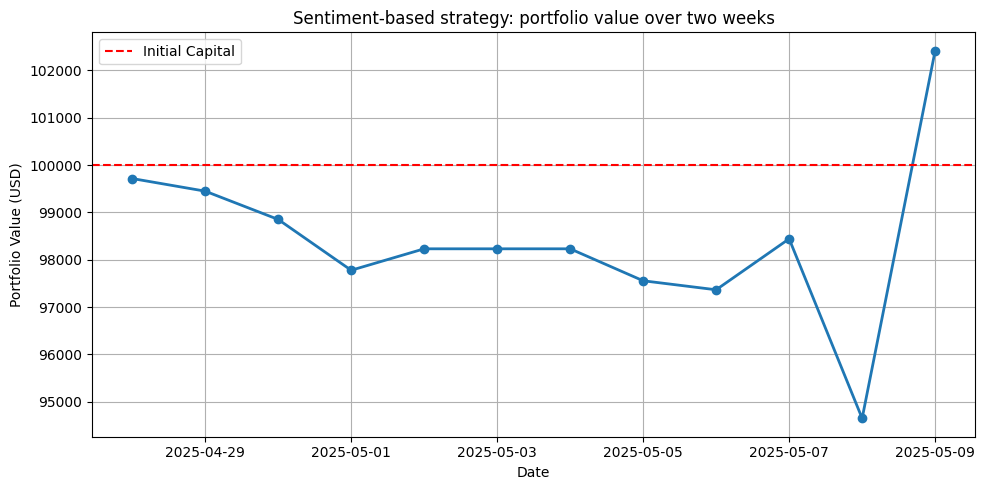

In [29]:
# Define parameters for the API and its functions

START_DATE = pd.to_datetime('2025-04-28')
END_DATE = pd.to_datetime('2025-05-09')
STOCK_UNIVERSE = ['AAPL', 'DNUT', 'BRK-B']

#1) Get your sentiment surface

sentiment_df = gather_daily_sentiments(STOCK_UNIVERSE, START_DATE, END_DATE)

# 2) Pull in all your price data

price_dict = fetch_price_data(STOCK_UNIVERSE, START_DATE, END_DATE)

# Now you will have:
# - sentiment_df.loc[date, stock] which is polarity of the stock on that date
# - price_dict[stock].loc[date, ['Open', 'Close']] prices

# Daily sentiment per stock

sentiment_df

# Price data for each stock

print(price_dict['DNUT'])

# IMport backtesting functionality from python file

from momentum_functions import backtest_sentiment_strategy

# Example usage

results = backtest_sentiment_strategy(sentiment_df, price_dict, init_capital=100000)
results

# Plot the portfolio value

plt.figure(figsize=(10, 5))
plt.plot(results.index, results['portfolio_value'], marker = 'o', linewidth = 2)
plt.title('Sentiment-based strategy: portfolio value over two weeks')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (USD)')
plt.axhline(y=100000, color='r', linestyle='--', label='Initial Capital')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


